In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000328_08_03_180.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000223_09_02_146.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000229_03_04_202.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000103_01_01_104.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000103_12_01_075.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000143_04_02_153.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/002276_05_03_078.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000020_03_01_166.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000054_03_01_025.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000230_04_01_242.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000058_07_01_170.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000058_07_01_195.png
/kaggle/input/iqothnccd-lung-cancer-dataset/Test cases/000230_03_02_166.png
/kaggle/inpu

# Step 1: Reading and Understanding the Data
Let's start with the following steps:

1) Importing data using the pandas library




2) Understanding the structure of the data

In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Importing libraries and package
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter


import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE


In [5]:
directory = '../input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
cases = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Image Preprocessing

In [ ]:
size_data = {}
for i in cases:
    path = os.path.join(directory, i)
    class_num = cases.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

Bengin cases


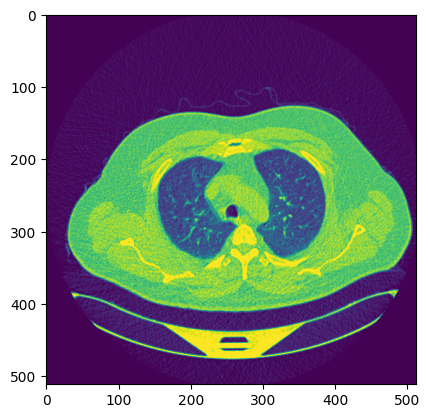

Malignant cases


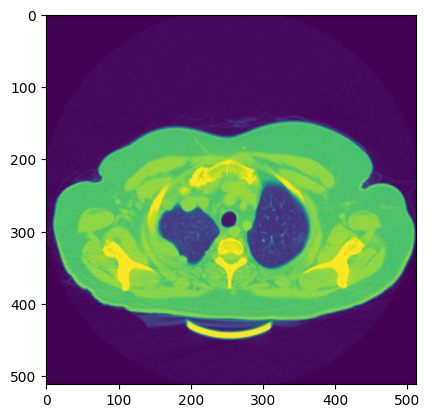

Normal cases


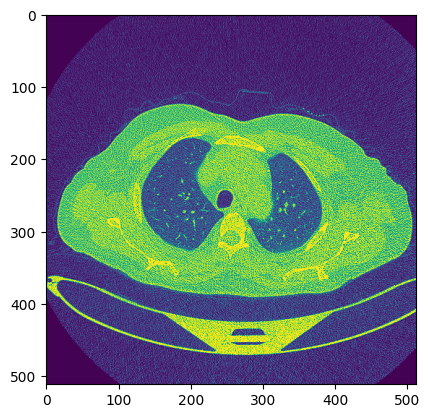

In [8]:
for i in cases:
    path = os.path.join(directory, i)
    class_num = cases.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

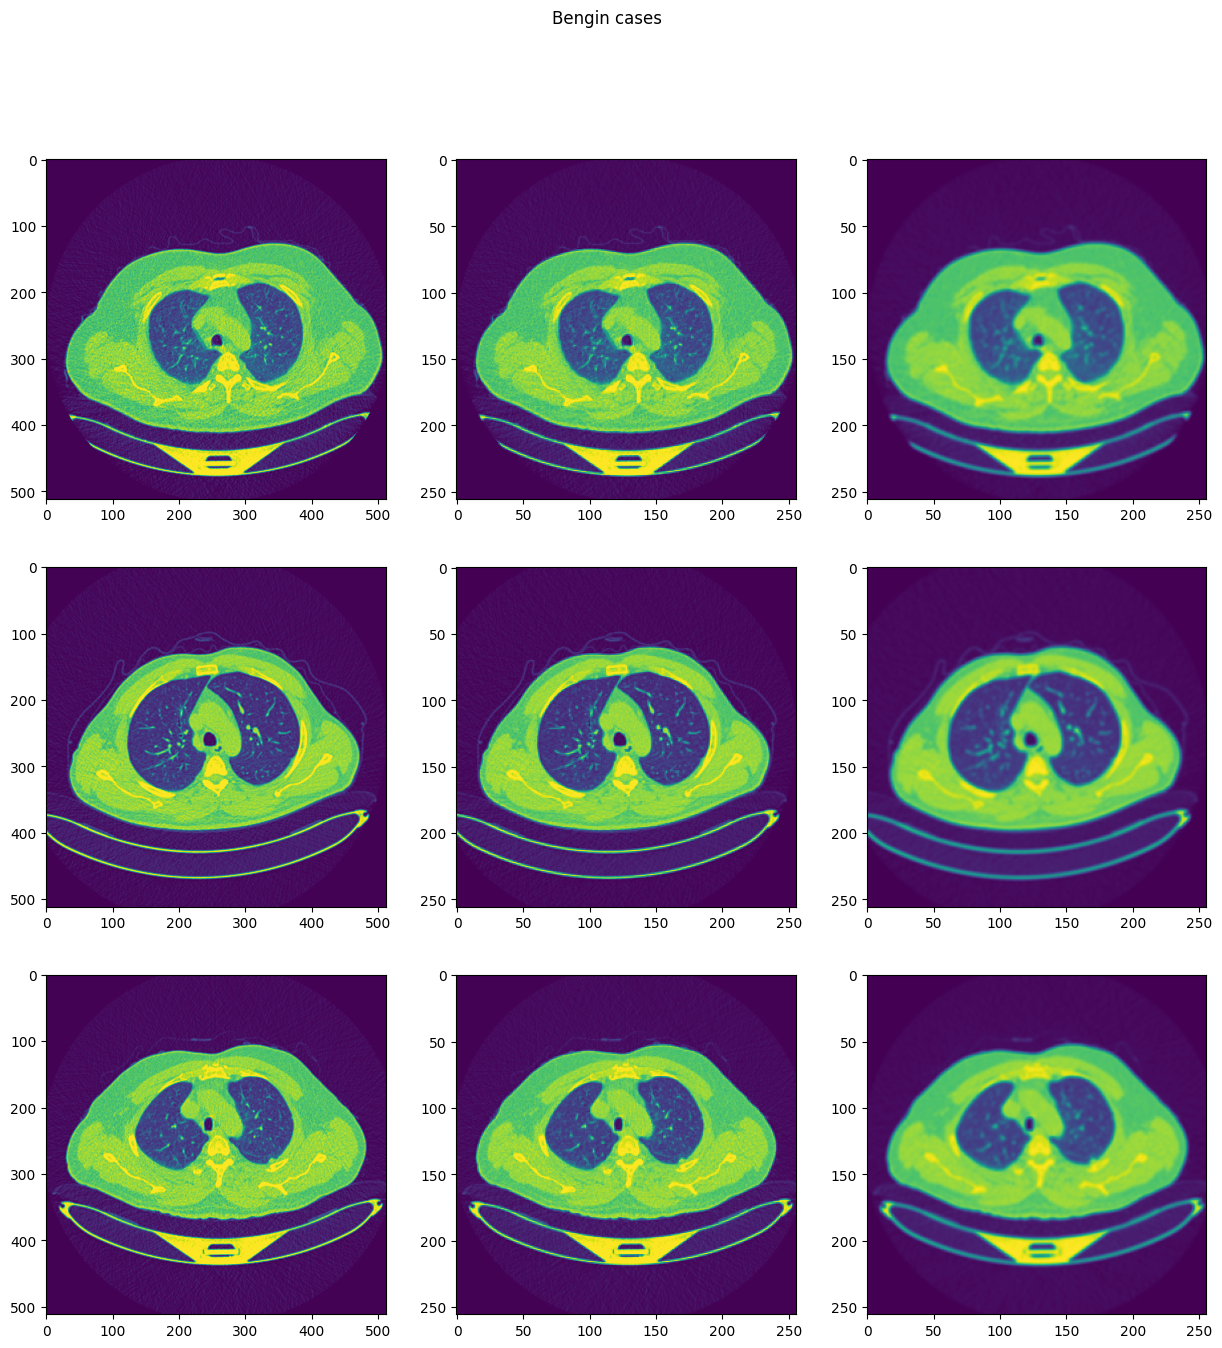

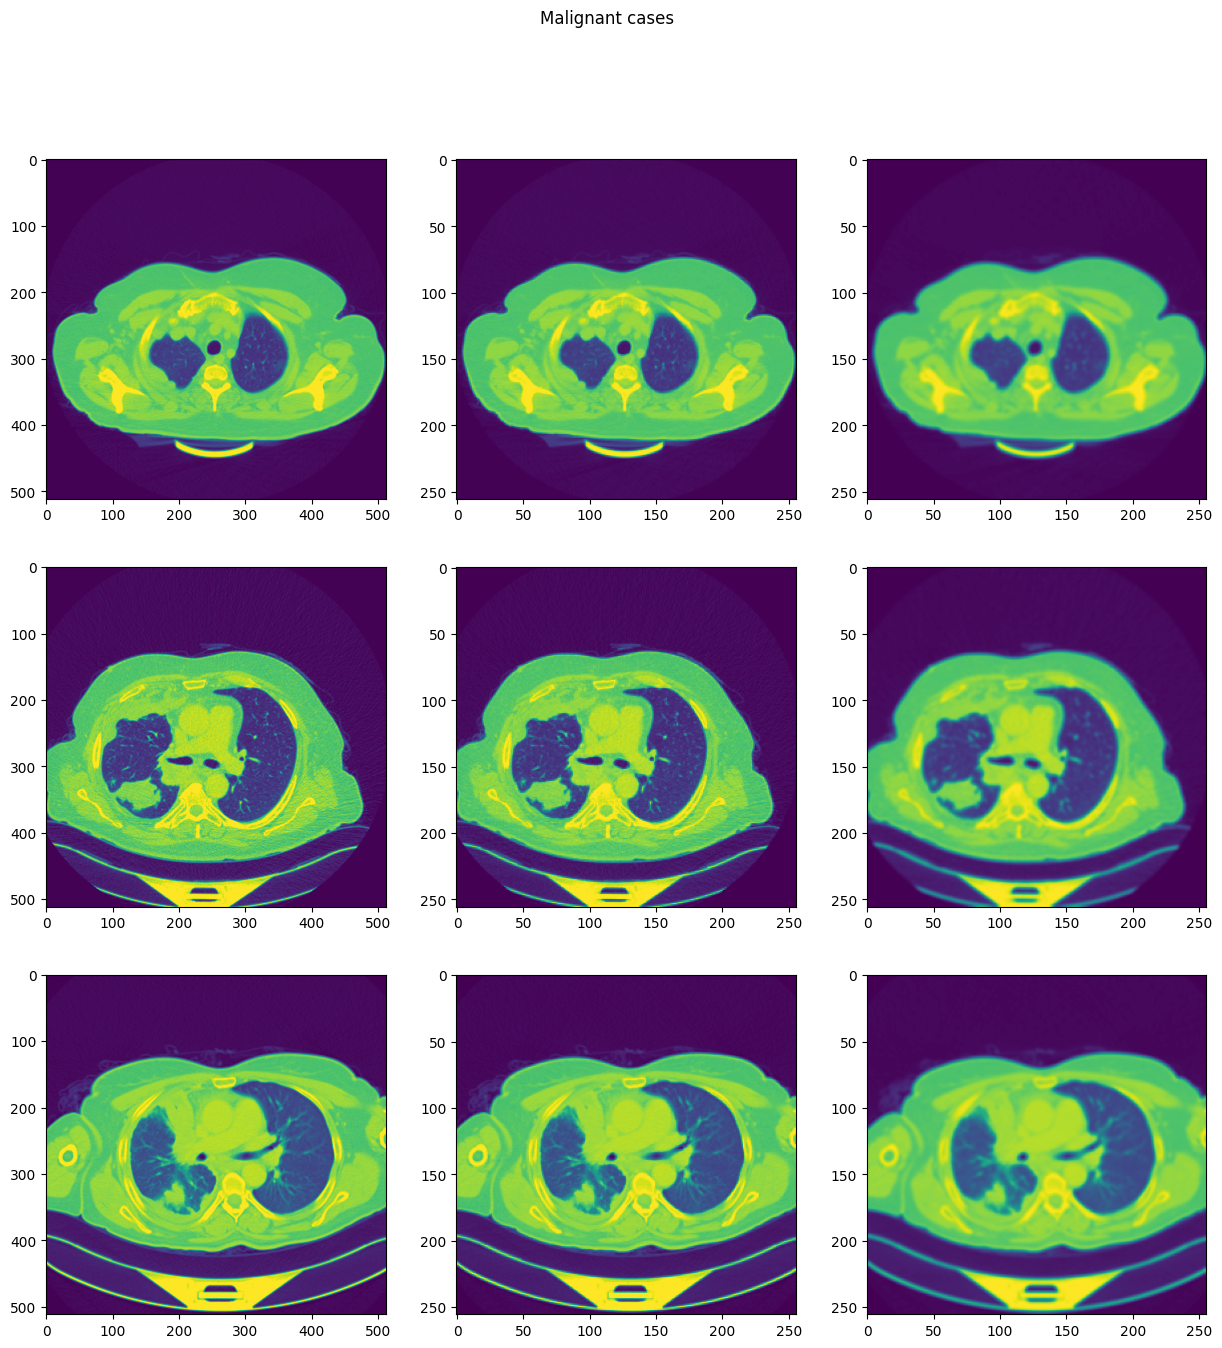

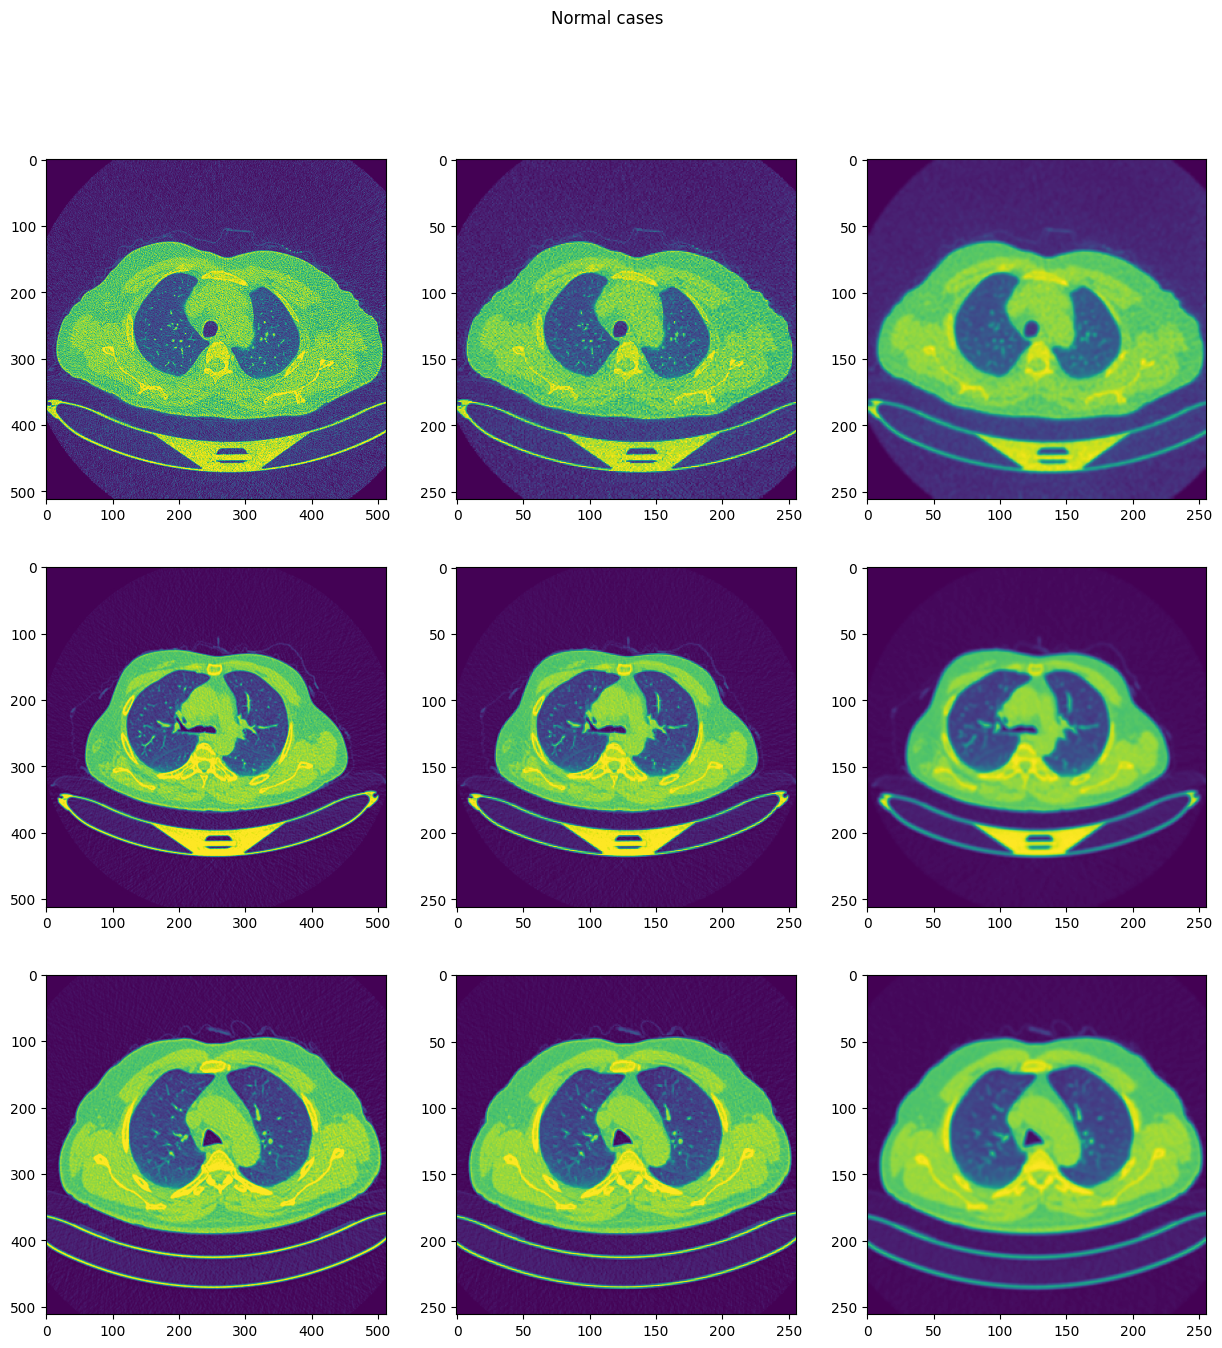

In [9]:
img_size = 256
for i in cases:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = cases.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

# Data Preperation

In [12]:
data = []
img_size = 256

for i in cases:
    path = os.path.join(directory, i)
    class_num = cases.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


# Data Split


Divide the dataset into training, validation, and test sets. The training set is used to train the model, the validation set is used for hyperparameter tuning, and the test set is used to evaluate the model's performance.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


In [17]:
df_trainGen = ImageDataGenerator()
df_validGen = ImageDataGenerator()

In [18]:
train_generator = df_trainGen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = df_validGen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

# Building Machine Learning Model

In [19]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet_base)

# Added custom classification layers on top
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40,359,171
Trainable params: 16,777,731
Non-trainable params: 23,581,440
_________________________________________________________________


In [20]:
# simple early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [21]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
103/103 [==============================] - 172s 2s/step - loss: 0.9282 - accuracy: 0.5730 - val_loss: 0.7413 - val_accuracy: 0.7018
Epoch 2/20
103/103 [==============================] - 168s 2s/step - loss: 0.7217 - accuracy: 0.6983 - val_loss: 0.5084 - val_accuracy: 0.8255
Epoch 3/20
103/103 [==============================] - 169s 2s/step - loss: 0.5716 - accuracy: 0.7725 - val_loss: 0.4757 - val_accuracy: 0.8836
Epoch 4/20
103/103 [==============================] - 169s 2s/step - loss: 0.4543 - accuracy: 0.8297 - val_loss: 0.3821 - val_accuracy: 0.8473
Epoch 5/20
103/103 [==============================] - 163s 2s/step - loss: 0.3665 - accuracy: 0.8759 - val_loss: 0.3463 - val_accuracy: 0.8400
Epoch 6/20
103/103 [==============================] - 168s 2s/step - loss: 0.3100 - accuracy: 0.9015 - val_loss: 0.3600 - val_accuracy: 0.9018
Epoch 7/20
103/103 [==============================] - 163s 2s/step - loss: 0.3135 - accuracy: 0.8905 - val_loss: 0.3078 - val_accuracy: 0.8873

In [23]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 40s 4s/step
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        21
           1       1.00      0.80      0.89       150
           2       0.72      0.97      0.83       104

    accuracy                           0.85       275
   macro avg       0.84      0.78      0.79       275
weighted avg       0.88      0.85      0.85       275

[[ 12   0   9]
 [  0 120  30]
 [  3   0 101]]


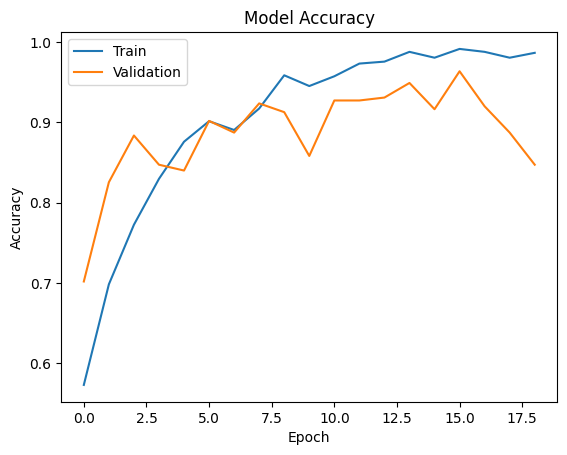

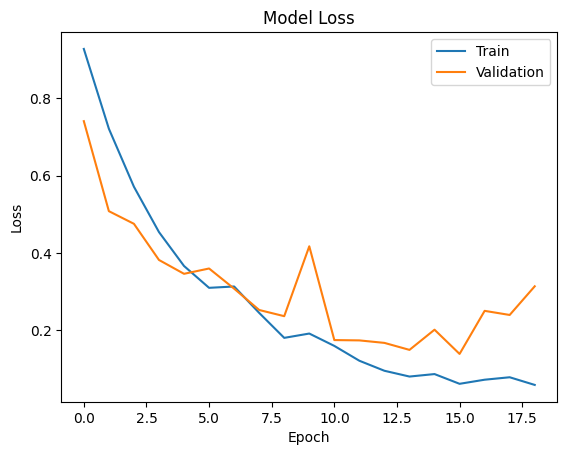

In [24]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

NameError: name 'img_width' is not defined

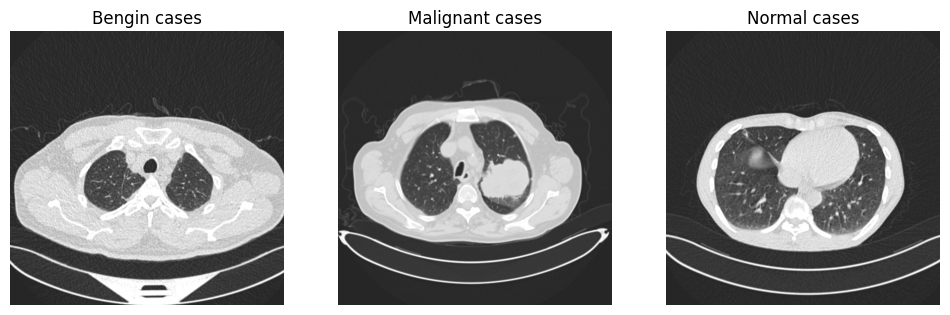

In [25]:
from tensorflow.keras.preprocessing import image

prediction_img = ['/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (117).jpg',
                   '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (387).jpg', 
                  '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (327).jpg']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

for i in range(3):
    img = cv2.imread(prediction_img[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(cases[i])
    
for i in prediction_img:
    img = image.load_img(i, target_size=(img_width, img_height))
    img_arr = image.img_to_array(img)
    img_arr= np.expand_dims(img_arr, axis=0)
    img_arr= img_arr/255
    predictions = model.predict(img_arr)
    predicted_class = np.argmax(predictions)
    if predicted_class == 0:
        print('Benign')
    elif predicted_class == 1:
        print('Malignant')
    else:
        print('Normal')